<a href="https://colab.research.google.com/github/SeanTan03/capstone-transfer-learning-pipeline/blob/main/capstone_TL_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Severstal Steel Defect Detection - A ML Training Pipeline

##Environment setup

###Environment imports

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_pre
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_pre
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf
import os
import seaborn as sns
import time

!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.6 MB/s eta 0:00:00


###Environment verification

In [ ]:
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.test.is_gpu_available()}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TensorFlow version: 2.18.0
GPU available: True


###Environment constants

In [ ]:
DATASET_NAME = 'severstal-steel-defect-detection'
BATCH_SIZE = 32

##Dataset preparation

###Kaggle API

In [ ]:
!mkdir -p ~/.kaggle

if os.path.exists('kaggle.json'):
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API credentials configured")
else:
    print("kaggle.json file not uploaded to runtime storage")

Kaggle API credentials configured


###Dataset download

In [ ]:
if not os.path.exists(f'/content/{DATASET_NAME}'):
    print("Downloading dataset")
    !kaggle competitions download -c {DATASET_NAME}
    !unzip -q {DATASET_NAME}.zip -d {DATASET_NAME}
    print("Dataset downloaded")
else:
    print("Dataset already exists, skipping download")

100% 1.57G/1.57G [00:09<00:00, 269MB/s]
100% 1.57G/1.57G [00:09<00:00, 180MB/s]
Dataset downloaded


###Data loading

In [ ]:
df = pd.read_csv(f'/content/{DATASET_NAME}/train.csv')
#simplify multi-hot to defect/no-defect
labels_map = df.groupby('ImageId')['EncodedPixels'].apply(lambda x: 0 if x.isna().all() else 1).to_dict()
# Get unique image list
image_dir = Path(f'/content/{DATASET_NAME}/train_images')
image_files = list(image_dir.glob('*.jpg'))

###Dataset preprocessing

In [ ]:
'''def load_and_preprocess(files, target_size, preprocess_fn):
    images = []
    labels = []
    for img_path in files:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        arr = np.array(img)
        images.append(arr)
        labels.append(labels_map.get(img_path.name, 0))
    X = np.array(images)
    y = np.array(labels)
    X = preprocess_fn(X)
    return X, y'''

#tackle memory usage
def load_and_preprocess_batch(model, preprocess_fn, target_size, image_files, batch_size=BATCH_SIZE):
    df_gen = pd.DataFrame({'filename': [str(f) for f in image_files]})
    df_gen['class'] = df_gen['filename'].map(lambda x: labels_map.get(Path(x).name, 0))
    datagen = ImageDataGenerator(preprocessing_function=preprocess_fn)

    generator = datagen.flow_from_dataframe(
        dataframe=df_gen,
        x_col="filename",
        y_col="class",
        target_size=target_size,
        batch_size=batch_size,
        class_mode="raw",
        shuffle=False
    )

    start = time.time()
    features = model.predict(generator, verbose=1)
    elapsed = time.time() - start
    labels = generator.labels
    return features, labels, elapsed

##Pre-trained CNN feature extractors

###Define models

In [ ]:
cnn_models = {
    'resnet50': (ResNet50(weights='imagenet', include_top=False, pooling='avg'), resnet_pre, (224,224)),
    'vgg16':    (VGG16(weights='imagenet', include_top=False, pooling='avg'), vgg_pre, (224,224)),
    'inceptionv3': (InceptionV3(weights='imagenet', include_top=False, pooling='avg'), inception_pre, (299,299)),
}

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


###Extraction loop

In [ ]:
features = {}
labels = None
features_time = {}
for name, (model, pre_fn, size) in cnn_models.items():
    print(f"\nExtracting with {name}...")
    #X, y = load_and_preprocess(image_files, size, pre_fn)
    #feats = model.predict(X, batch_size=BATCH_SIZE, verbose=1)
    feats, y, time_elapsed = load_and_preprocess_batch(model, pre_fn, size, image_files)
    features[name] = feats
    labels = y  #same labels for all
    features_time[name] = round(time_elapsed, 3)
    joblib.dump(feats, f"features_{name}.pkl")

pd.DataFrame.from_dict(features_time, orient='index', columns=['Extraction Time (s)'])


Extracting with resnet50...
Found 12568 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 70s 162ms/step

Extracting with vgg16...
Found 12568 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 90s 199ms/step

Extracting with inceptionv3...
Found 12568 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


393/393 ━━━━━━━━━━━━━━━━━━━━ 98s 216ms/step


,Extraction Time (s)
resnet50,71.121
vgg16,142.166
inceptionv3,98.480


##Create train/test split

In [ ]:
splits = {}
for name, feats in features.items():
    X_train, X_test, y_train, y_test = train_test_split(
        feats, labels, test_size=0.3, random_state=42, stratify=labels
    )
    splits[name] = (X_train, X_test, y_train, y_test)

##Traditional classifiers

###Define classifiers

In [ ]:
classifiers = {
    'SVM': SVC(probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features=0.3)
}

###Classification loop


Training SVM on resnet50 features...
Training time elapsed: 220.4164423942566
Testing time elapsed: 76.68145060539246


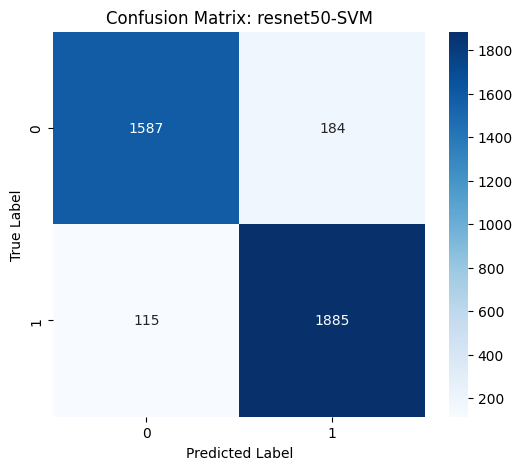


Training KNN on resnet50 features...
Training time elapsed: 0.010189056396484375
Testing time elapsed: 11.14762258529663


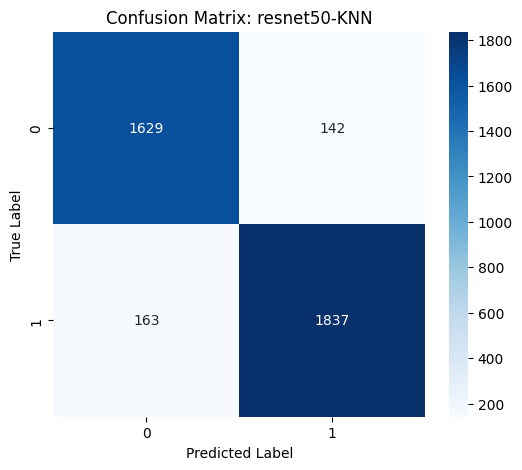


Training RandomForest on resnet50 features...
Training time elapsed: 538.5404696464539
Testing time elapsed: 0.415802001953125


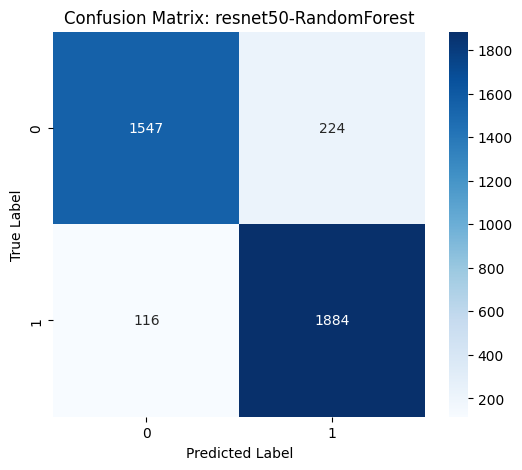


Training SVM on vgg16 features...
Training time elapsed: 56.92316794395447
Testing time elapsed: 21.959226608276367


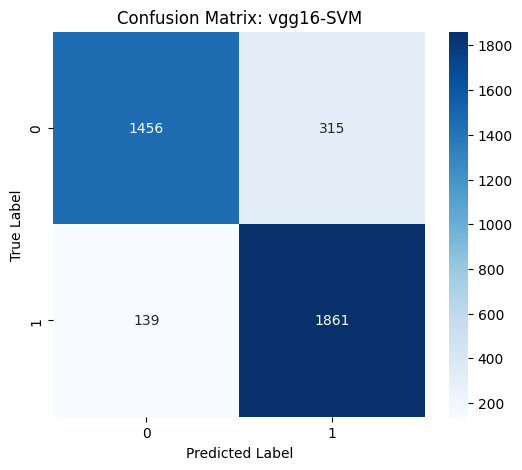


Training KNN on vgg16 features...
Training time elapsed: 0.0029337406158447266
Testing time elapsed: 3.7004430294036865


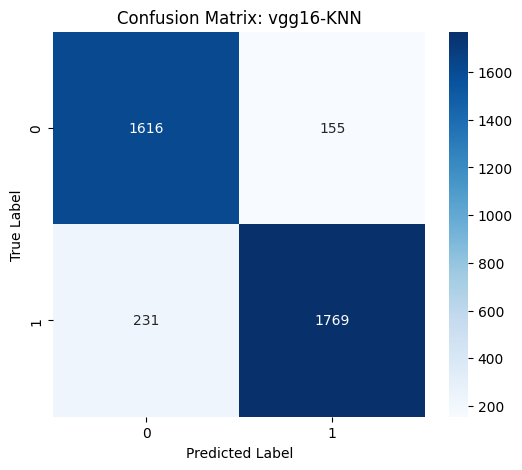


Training RandomForest on vgg16 features...
Training time elapsed: 106.49004793167114
Testing time elapsed: 0.2782139778137207


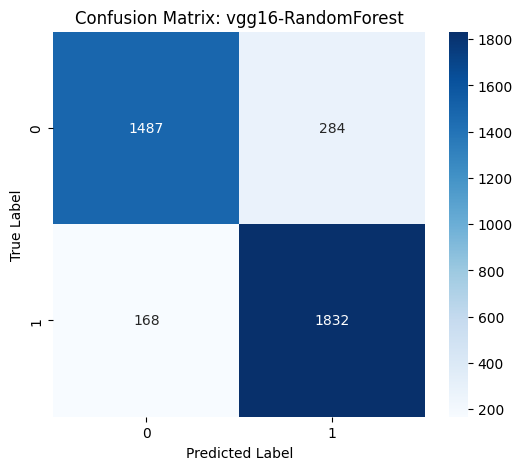


Training SVM on inceptionv3 features...
Training time elapsed: 223.5615074634552
Testing time elapsed: 75.51276063919067


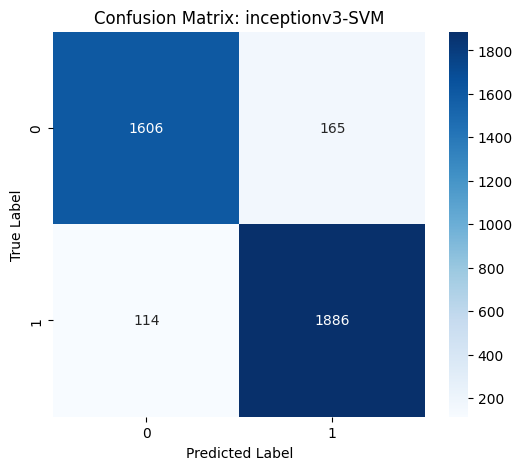


Training KNN on inceptionv3 features...
Training time elapsed: 0.006783008575439453
Testing time elapsed: 10.999597787857056


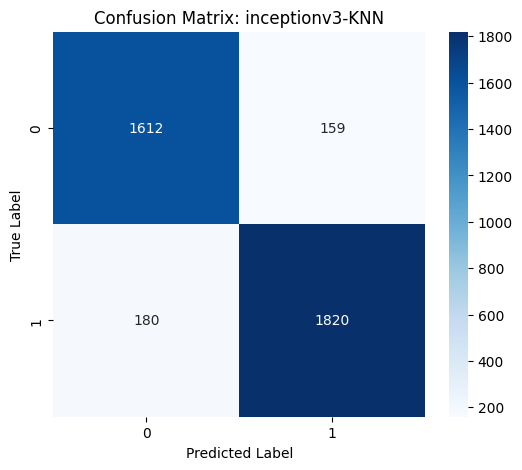


Training RandomForest on inceptionv3 features...
Training time elapsed: 862.3321940898895
Testing time elapsed: 0.4057331085205078


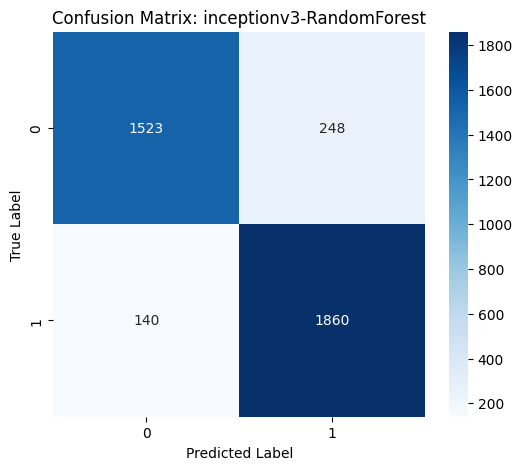

In [ ]:
results = []
for cnn_name, (X_train, X_test, y_train, y_test) in splits.items():
    for clf_name, clf in classifiers.items():
        print(f"\nTraining {clf_name} on {cnn_name} features...")

        start_train = time.time()
        clf.fit(X_train, y_train)
        train_time = time.time() - start_train

        print(f"Training time elapsed: {train_time}")

        start_test = time.time()
        y_pred_train = clf.predict(X_train)
        y_pred_test  = clf.predict(X_test)
        test_time = time.time() - start_test

        print(f"Testing time elapsed: {test_time}")

        cm = confusion_matrix(y_test, y_pred_test)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix: {cnn_name}-{clf_name}")
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        '''plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title(f"Confusion Matrix: {cnn_name}-{clf_name}")
        plt.colorbar()
        plt.savefig(f"cm_{cnn_name}_{clf_name}.png")
        plt.close()
        joblib.dump(clf, f"model_{cnn_name}_{clf_name}.pkl")'''

        metrics = {
            'CNN': cnn_name,
            'Classifier': clf_name,
            'Train Accuracy': accuracy_score(y_train, y_pred_train),
            'Test Accuracy': accuracy_score(y_test, y_pred_test),
            'Test Precision': precision_score(y_test, y_pred_test),
            'Test Recall': recall_score(y_test, y_pred_test),
            'Test F1': f1_score(y_test, y_pred_test),
            'CM_TN': cm[0,0],
            'CM_FP': cm[0,1],
            'CM_FN': cm[1,0],
            'CM_TP': cm[1,1],
            'Train Time (s)': round(train_time, 3),
            'Test Time (s)': round(test_time, 3)
        }
        results.append(metrics)

##Results

In [ ]:
df_results = pd.DataFrame(results)

df_results['Confusion Matrix'] = df_results.apply(
    lambda r: (
        f"TN: {r['CM_TN']}"
        f"FP: {r['CM_FP']}"
        f"FN: {r['CM_FN']}"
        f"TP: {r['CM_TP']}"
    ),
    axis=1
)

df_export = df_results.drop(columns=['CM_TN', 'CM_FP', 'CM_FN', 'CM_TP'])

if 'feature_times' not in globals():
    feature_times = {}
df_times = pd.DataFrame.from_dict(feature_times, orient='index', columns=['Extraction Time (s)']).reset_index()
df_times.rename(columns={'index': 'CNN'}, inplace=True)

with pd.ExcelWriter('pipeline_results.xlsx', engine='xlsxwriter') as writer:
    df_export.to_excel(writer, index=False, sheet_name='Metrics')

    workbook  = writer.book
    worksheet = writer.sheets['Metrics']

    cm_col_idx = df_export.columns.get_loc('Confusion Matrix')
    wrap_fmt = workbook.add_format({'text_wrap': True})
    worksheet.set_column(cm_col_idx, cm_col_idx, 20, wrap_fmt)

print("Exported pipeline_results.xlsx")


Exported pipeline_results.xlsx
